# Imports

In [29]:
!pip install tensorboard
!pip install torch_optimizer

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [30]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
# from skimage import io,transform,img_as_ubyte
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import math
import time
from datetime import datetime
import shutil
import tensorboard
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
from PIL import Image, ImageDraw, ImageFont
import torchvision.utils as vutils
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import confusion_matrix
import itertools
import torch.distributed as dist
import torch.multiprocessing as mp
from sklearn.model_selection import train_test_split
from torch_optimizer import Lookahead

# Dataset and dataloaders

In [31]:
class ZooplanktonDataset(Dataset):
    def __init__(self, csv, cropped_image_folder, transform=None):
        self.annotations = pd.read_csv(csv)
        self.cropped_image_folder = cropped_image_folder
        self.transform = transform
        self.labels = np.array(self.annotations.iloc[:, 1])
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]
        cropped_img_path = os.path.join(self.cropped_image_folder, img_name)
        
        image = Image.open(cropped_img_path).convert('RGB')
        
        y_label = self.annotations.iloc[index, 1]
            
        if self.transform:
            image = self.transform(image)
        
        return image, y_label


In [32]:
# # Downsampleing Majority class

# from sklearn.utils import resample
# class ZooplanktonDataset(Dataset):
#     def __init__(self, csv, cropped_image_folder, transform=None):
#         self.labels = pd.read_csv(csv)  
#         self.cropped_image_folder = cropped_image_folder
#         self.transform = transform
        
#         # Separate samples for classes 0 and 1
#         class_0_samples = self.labels[self.labels['Label'] == 0]
#         class_1_samples = self.labels[self.labels['Label'] == 1]
        
#         # Downsample class 0 to match the size of class 1
#         class_0_downsampled = resample(class_0_samples,
#                                        replace=False,  # Without replacement
#                                        n_samples=len(class_1_samples),
#                                        random_state=42)  # For reproducibility
        
#         # Concatenate downsampled class 0 and class 1 samples
#         self.labels = pd.concat([class_0_downsampled, class_1_samples])
#         self.labels = self.labels.sample(frac=1).reset_index(drop=True)  # Shuffle
        
#     def __len__(self):
#         return len(self.labels)
    
#     def __getitem__(self, index):
#         img_name = self.labels.iloc[index, 0]  # Change from self.annotations to self.labels
#         cropped_img_path = os.path.join(self.cropped_image_folder, img_name)
        
#         image = Image.open(cropped_img_path).convert('RGB')
        
#         y_label = self.labels.iloc[index, 1]  # Change from self.annotations to self.labels
            
#         if self.transform:
#             image = self.transform(image)
        
#         return image, y_label


In [33]:
# # Upsampling Minority class

# def custom_collate(batch):
#     images, labels = zip(*batch)
#     images = torch.stack([transforms.ToTensor()(img) for img in images], dim=0)
#     labels = torch.tensor(labels)
#     return images, labels

# from sklearn.utils import resample
# import os
# import pandas as pd
# from PIL import Image
# from torch.utils.data import Dataset
# from torchvision import transforms

# class ZooplanktonDataset(Dataset):
#     def __init__(self, csv, cropped_image_folder, transform=None):
#         self.labels = pd.read_csv(csv)  
#         self.cropped_image_folder = cropped_image_folder
#         self.transform = transform
        
#         class_0_samples = self.labels[self.labels['Label'] == 0]
#         class_1_samples = self.labels[self.labels['Label'] == 1]
        
#         # Upsample class 1 to match the size of class 0
#         class_1_upsampled = resample(class_1_samples,
#                                      replace=True,  # With replacement for upsampling
#                                      n_samples=len(class_0_samples),
#                                      random_state=42)
        
#         self.labels = pd.concat([class_0_samples, class_1_upsampled])
#         self.labels = self.labels.sample(frac=1).reset_index(drop=True)
        
#     def __len__(self):
#         return len(self.labels)
    
#     def __getitem__(self, index):
#         img_name = self.labels.iloc[index, 0]
#         cropped_img_path = os.path.join(self.cropped_image_folder, img_name)
        
#         image = Image.open(cropped_img_path).convert('RGB')
        
#         y_label = self.labels.iloc[index, 1]
            
#         if self.transform:
#             image = self.transform(image)
        
#         return image, y_label


# Train and Test split 

In [34]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# data_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(0.5),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# random_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(degrees=20)
# ])

# dataset = ZooplanktonDataset(csv='/home/ec2-user/SageMaker/All_csv_combined/annotations.csv',cropped_image_folder='/home/ec2-user/SageMaker/dataset/uncropped+predictions1',
#                             transform=data_transform)

dataset = ZooplanktonDataset(csv='/home/ec2-user/SageMaker/All_csv_combined/annotations.csv',
                             cropped_image_folder='/home/ec2-user/SageMaker/dataset/uncropped+predictions1',
                             transform=data_transform)

from torch.utils.data import Subset

# # Splitting the indices into train and test sets with a stratified split
train_indices, test_indices = train_test_split(
    np.arange(len(dataset)), test_size=0.2, stratify=dataset.labels
)

# train_indices, test_indices = train_test_split(
#     np.arange(len(dataset)), test_size=0.2
# )

# Create subset datasets using the train and test indices
train_set = Subset(dataset, train_indices)
test_set = Subset(dataset, test_indices)

train_loader = DataLoader(dataset=train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=16, shuffle=True)


# Models

In [35]:
class Model_v2(nn.Module):
    def __init__(self, dropout):
        super(Model_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        
        # Adjusting the fully connected layers to fit the spatial dimensions
        # of the input image (256x256)
        self.fc1 = nn.Linear(64 * 30 * 30, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 1)  # Output layer for binary classification (1 neuron for probability)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for probability output
        
    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout(F.relu(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(-1, 64 * 30 * 30)  # Adjusted view shape
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))  # Use sigmoid activation for probability output
        return x

In [36]:
# class Model_v2(nn.Module):
#     def __init__(self, dropout):
#         super(Model_v2, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3)
#         self.conv2 = nn.Conv2d(16, 32, 3)
#         self.conv3 = nn.Conv2d(32, 64, 3)
#         self.pool1 = nn.AdaptiveMaxPool2d((3, 3))
#         self.pool2 = nn.AdaptiveMaxPool2d((3, 3))
#         self.pool3 = nn.AdaptiveMaxPool2d((2, 2))
#         self.dropout = nn.Dropout(dropout)
        
#         # Adjusting the fully connected layers to fit the spatial dimensions
#         # of the input image (256x256)
#         self.fc1 = nn.Linear(64 * 2 * 2, 256)  # Adjusted input size
#         self.fc2 = nn.Linear(256, 84)
#         self.fc3 = nn.Linear(84, 1)
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, x):
#         x = self.dropout(F.relu(self.conv1(x)))
#         x = self.pool1(x)
#         x = self.dropout(F.relu(self.conv2(x)))
#         x = self.pool2(x)
#         x = self.dropout(F.relu(self.conv3(x)))
#         x = self.pool3(x)
        
#         # Flatten the tensor before fully connected layers
#         x = x.view(x.size(0), -1)
        
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.relu(self.fc2(x)))
#         x = self.sigmoid(self.fc3(x))
#         return x




# Loss curve 

In [37]:
class LossCurve:
    def __init__(self):
        self

    def PlotCurve(loss_values,epochs):
        plt.plot(range(epochs), loss_values, 'blue')
        plt.title('Loss decay')
        plt.xlabel('number of epochs')
        plt.ylabel('Loss')
        plt.show()

# Training Loop

In [38]:
class Trainer():
    def __init__(self, model, loss_criterion, threshold, train_data_loader, test_data_loader,
                 optimizer, epochs, with_cuda, use_scheduler, scheduler, save_dir, tensorboard_dir,
                 lr=0.001, print_freq=1):
        self.device = torch.device("cuda:0" if with_cuda else "cpu")
        self.model = model
        self.loss_criterion = loss_criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.with_cuda = with_cuda
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader
        self.lr = lr
        self.save_dir = save_dir
        self.tensorboard_dir = tensorboard_dir
        self.use_scheduler = use_scheduler
        self.scheduler = scheduler
        self.step = 0
        self.print_freq = print_freq
        self.start_time = datetime.now().strftime('%b-%d_%H-%M')
        self.save_freq = 1
        self.accuracy = 0
        self.threshold = threshold
        if not os.path.exists(self.tensorboard_dir):
            os.makedirs(self.tensorboard_dir)
        self.writer = SummaryWriter(log_dir=self.tensorboard_dir)
        
    def _train_epoch(self):
        loss_values = []
        
        for epoch in range(self.epochs):
            running_loss = 0
            last_step = self.step - 1
            last_time = time.time()
            batch_counter = 0
            accuracy = 0
            loop = tqdm(enumerate(self.train_data_loader), total=len(self.train_data_loader), leave=True)
            for batch_idx, (images, labels) in loop:
                if self.with_cuda:
                    images, labels = images.to(self.device), labels.to(self.device)
                self.model.train()
                batch_counter += 1
                # forward pass
                outputs = self.model(images)
                labels = labels.unsqueeze(1).float()
                # finding loss
                loss = self.loss_criterion(outputs, labels)
                # backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                if self.use_scheduler:
                    self.scheduler.step()

                running_loss += loss.item()
                # evaluation of model on test data
                if batch_counter % 1000 == 0 or batch_counter == len(self.train_data_loader):
                    accuracy = self._valid_epoch(self.model, epoch, self.test_data_loader)
                
                is_best = False
                if accuracy > self.accuracy:
                    is_best = True
                self.accuracy = accuracy
                
                if self.step % self.print_freq == self.print_freq - 1:
                    used_time = time.time() - last_time
                    step_num = self.step - last_step
                    speed = self.train_data_loader.batch_size * step_num / used_time
                    batch_loss = loss.item()
                    loop.set_description(f"Epoch[{epoch + 1}/{self.epochs}]")
                    loop.set_postfix(
                        lr=self.scheduler.get_last_lr(),
                        batch_loss=batch_loss,
                        global_loss=running_loss,
                        speed=speed,
                        accuracy=self.accuracy,
                        device=self.device
                    )
                    global_loss = 0.0
                    last_step = self.step
                    last_time = time.time()
                self.step += 1

            if epoch % self.save_freq == 0:
                self._save_checkpoint(epoch, is_best)
            
            self.writer.add_scalar('Loss', running_loss / len(self.train_data_loader), global_step=self.step)
            loss_values.append(running_loss / len(self.train_data_loader))
        
        print("Train Accuracy:", self._valid_epoch(self.model, self.epochs, self.train_data_loader))
        print("Validation Accuracy:", self._valid_epoch(self.model, self.epochs, self.test_data_loader))
        
        # Find the best threshold and its corresponding accuracy
        best_threshold, best_accuracy = self._find_best_threshold()
        print("Best Threshold:", best_threshold)
        print("Best Validation Accuracy:", best_accuracy)
        
        # Plotting Loss Curve
        self.writer.add_scalar('Best_Validation_Accuracy', best_accuracy, global_step=self.epochs)
        LossCurve.PlotCurve(loss_values, self.epochs)
        
        # logging images to Tensorboard
        self.log_images_after_training()
        
        # closing SummaryWriter Object
        self.writer.close()

    def _valid_epoch(self, model, epoch, test_loader, threshold=None):
        model.eval()
        if threshold is None:
            threshold = self.threshold  # Use the current threshold if not provided
        with torch.no_grad():
            correct_samples = 0
            total_samples = 0
            for images, labels in test_loader:
                if self.with_cuda:
                    images, labels = images.to(self.device), labels.to(self.device)
                pred_probs = model(images)
                pred_labels = (pred_probs > threshold).float()
                total_samples += labels.size(0)
                correct_samples += (pred_labels == labels.view(-1, 1).float()).sum().item()
            accuracy = (correct_samples / total_samples) * 100
            self.writer.add_scalar('Accuracy', accuracy, global_step=epoch)
            return accuracy

    def _find_best_threshold(self, num_thresholds=100):
        # Evaluate the model on the validation set for different thresholds
        thresholds = np.linspace(0.1, 1, num_thresholds)
        false_negatives = []
        for threshold in thresholds:
            false_negative = self._calculate_false_negatives(self.model, self.test_data_loader, threshold)
            false_negatives.append(false_negative)

        # Find the best threshold that gives the least false negatives
        best_idx = np.argmin(false_negatives)
        best_threshold = thresholds[best_idx]
        best_false_negative = false_negatives[best_idx]

        # Update the threshold in the class
        self.threshold = best_threshold

        return best_threshold, best_false_negative

    def _calculate_false_negatives(self, model, test_loader, threshold):
        model.eval()
        with torch.no_grad():
            false_negatives = 0
            total_positives = 0
            for images, labels in test_loader:
                if self.with_cuda:
                    images, labels = images.to(self.device), labels.to(self.device)
                pred_probs = model(images)
                pred_labels = (pred_probs > threshold).float()

                # Count the number of false negatives (predicted as negative but actually positive)
                false_negatives += ((pred_labels == 0) & (labels == 1)).sum().item()
                total_positives += (labels == 1).sum().item()

            false_negative_rate = false_negatives / max(total_positives, 1)  # Avoid division by zero
            return false_negative_rate

    
    def _save_checkpoint(self, epoch, is_best):
        arch = type(self.model).__name__
        state = {
            'epoch': epoch,
            'arch': arch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'accuracy': self.accuracy,
            'step': self.step + 1,
            'start_time': self.start_time}
        filename = os.path.join(
            self.save_dir + 'checkpoint_{}_epoch{:02d}_acc_{:.5f}.pth.tar'.format(
                arch, epoch, self.accuracy))
        print("Saving checkpoint: {} ...".format(filename))
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(
                filename, os.path.join(self.save_dir, '{}_binary_best.pth.tar'.format(arch)))
        return filename

    def log_images_after_training(self):
        arch = type(self.model).__name__
        checkpoint = torch.load('/home/ec2-user/SageMaker/checkpoints/uncropped/{}_binary_best.pth.tar'.format(arch))
        self.model.load_state_dict(checkpoint['state_dict'])
        self.model.eval()
        images = []
        true_labels = []
        predicted_labels = []

        for batch_images, batch_labels in self.test_data_loader:
            with torch.no_grad():
                if self.with_cuda:
                    batch_images, batch_labels = batch_images.to(self.device), batch_labels.to(self.device)

                # Forward pass to obtain predicted labels for each item in the batch
                batch_outputs = self.model(batch_images)
                batch_predicted_labels = (batch_outputs >= self.threshold).float()  # Convert probabilities to binary predictions (0 or 1)
            # Iterate over each item in the batch
            for i in range(batch_images.size(0)):
                image = vutils.make_grid(batch_images[i], nrow=1, padding=10, normalize=True) 
                true_label = batch_labels[i]
                predicted_label = batch_predicted_labels[i]

                images.append(image)
                true_labels.append(true_label)
                predicted_labels.append(predicted_label)

        for i in range(len(images)):
            image = images[i]
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]

            # Set the image name as the predicted and true labels
            image_name = f"Image-{i}-True-{true_label}-Predicted-{predicted_label}"

            # Log the image on TensorBoard with the image name
            self.writer.add_image(image_name, image.cpu(), global_step=i)

        #creating confusion matrix
        true_labels = torch.tensor(true_labels)
        predicted_labels = torch.tensor(predicted_labels)

        cm = confusion_matrix(true_labels, predicted_labels)

        fig = plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()

        # Set the axis labels and ticks
        class_names = ['Zooplankton', 'Marine-Snow']
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)

        # Add labels to each cell of the confusion matrix
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        # Save the confusion matrix figure to TensorBoard
        self.writer.add_figure('Confusion Matrix', fig)

# Hyperparameters

In [39]:
    #model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Model_v2(0.2)
    model.to(device)
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    # Base Optimizer
    base_optimizer = optim.RAdam(
        params=parameters,
        lr=0.001,
        betas=(0.8, 0.999),
        eps=1e-8,
        weight_decay=1e-5)

    #Lookahead optimizer
    optimizer = Lookahead(base_optimizer, k=10, alpha=0.5)  
    #scheduler
    lr_warm_up_num = 100
    cr = 1.0 / math.log(lr_warm_up_num)
    scheduler = optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda ee: cr * math.log(ee + 1)
        if ee < lr_warm_up_num else 1)
    data = pd.read_csv('/home/ec2-user/SageMaker/All_csv_combined/Test/annotations.csv')
    label_counts = data.iloc[:, 1].value_counts()
    loss_ratio = label_counts[0] / label_counts[1]
    class_weights = torch.Tensor([1,1]).to(device)  # Inverse ratio of class frequencies
    print("Class Weights:", class_weights)

    # Define the BCE loss with class weights
    loss_criterion = torch.nn.BCELoss(class_weights[1])
    #creating object for tensorboard_dir
    tensorboard_dir = '/home/ec2-user/SageMaker/runs/'


Class Weights: tensor([1., 1.], device='cuda:0')


# Trainer Object

In [40]:
   trainer = Trainer(
        model, loss_criterion,
        train_data_loader=train_loader,
        threshold = 0.8,
        test_data_loader=test_loader,
        optimizer=optimizer,
        epochs=30,
        with_cuda=True,
        use_scheduler=True,
        scheduler=scheduler,
        save_dir='/home/ec2-user/SageMaker/checkpoints/uncropped/',
        tensorboard_dir=tensorboard_dir,
        lr=0.001)
 

# Final Training

Epoch[1/30]: 100%|██████████| 855/855 [01:17<00:00, 10.99it/s, accuracy=85.6, batch_loss=0.925, device=cuda:0, global_loss=372, lr=[0.001], speed=1.36]              


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch00_acc_85.57214.pth.tar ...


Epoch[2/30]: 100%|██████████| 855/855 [01:04<00:00, 13.24it/s, accuracy=85.5, batch_loss=0.431, device=cuda:0, global_loss=343, lr=[0.001], speed=1.83]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch01_acc_85.54287.pth.tar ...


Epoch[3/30]: 100%|██████████| 855/855 [01:03<00:00, 13.56it/s, accuracy=85.6, batch_loss=0.777, device=cuda:0, global_loss=318, lr=[0.001], speed=1.83]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch02_acc_85.57214.pth.tar ...


Epoch[4/30]: 100%|██████████| 855/855 [01:05<00:00, 13.09it/s, accuracy=85.6, batch_loss=0.804, device=cuda:0, global_loss=298, lr=[0.001], speed=1.48]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch03_acc_85.57214.pth.tar ...


Epoch[5/30]: 100%|██████████| 855/855 [01:03<00:00, 13.47it/s, accuracy=85.6, batch_loss=0.0643, device=cuda:0, global_loss=271, lr=[0.001], speed=1.82]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch04_acc_85.63067.pth.tar ...


Epoch[6/30]: 100%|██████████| 855/855 [01:03<00:00, 13.52it/s, accuracy=85.6, batch_loss=0.0686, device=cuda:0, global_loss=281, lr=[0.001], speed=1.82]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch05_acc_85.60140.pth.tar ...


Epoch[7/30]: 100%|██████████| 855/855 [01:04<00:00, 13.24it/s, accuracy=85.7, batch_loss=0.17, device=cuda:0, global_loss=242, lr=[0.001], speed=1.81]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch06_acc_85.71847.pth.tar ...


Epoch[8/30]: 100%|██████████| 855/855 [01:09<00:00, 12.32it/s, accuracy=86.2, batch_loss=0.00182, device=cuda:0, global_loss=212, lr=[0.001], speed=1.57]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch07_acc_86.21598.pth.tar ...


Epoch[9/30]: 100%|██████████| 855/855 [01:03<00:00, 13.37it/s, accuracy=86.2, batch_loss=0.0525, device=cuda:0, global_loss=191, lr=[0.001], speed=1.82]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch08_acc_86.24524.pth.tar ...


Epoch[10/30]: 100%|██████████| 855/855 [01:03<00:00, 13.39it/s, accuracy=86.9, batch_loss=0.1, device=cuda:0, global_loss=174, lr=[0.001], speed=1.81] 


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch09_acc_86.91835.pth.tar ...


Epoch[11/30]: 100%|██████████| 855/855 [01:03<00:00, 13.48it/s, accuracy=86.6, batch_loss=0.0182, device=cuda:0, global_loss=146, lr=[0.001], speed=1.82]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch10_acc_86.59643.pth.tar ...


Epoch[12/30]: 100%|██████████| 855/855 [01:03<00:00, 13.45it/s, accuracy=86.9, batch_loss=0.406, device=cuda:0, global_loss=135, lr=[0.001], speed=1.81]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch11_acc_86.88908.pth.tar ...


Epoch[13/30]: 100%|██████████| 855/855 [01:04<00:00, 13.28it/s, accuracy=87.6, batch_loss=0.000348, device=cuda:0, global_loss=107, lr=[0.001], speed=1.82]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch12_acc_87.64999.pth.tar ...


Epoch[14/30]: 100%|██████████| 855/855 [01:03<00:00, 13.53it/s, accuracy=87.4, batch_loss=0.0116, device=cuda:0, global_loss=84.6, lr=[0.001], speed=1.82]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch13_acc_87.35733.pth.tar ...


Epoch[15/30]: 100%|██████████| 855/855 [01:04<00:00, 13.21it/s, accuracy=87.6, batch_loss=0.0537, device=cuda:0, global_loss=81.5, lr=[0.001], speed=1.57]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch14_acc_87.62072.pth.tar ...


Epoch[16/30]: 100%|██████████| 855/855 [01:03<00:00, 13.47it/s, accuracy=88.2, batch_loss=0.00746, device=cuda:0, global_loss=65.7, lr=[0.001], speed=1.82]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch15_acc_88.20603.pth.tar ...


Epoch[17/30]: 100%|██████████| 855/855 [01:03<00:00, 13.54it/s, accuracy=88.2, batch_loss=0.0046, device=cuda:0, global_loss=62.3, lr=[0.001], speed=1.82]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch16_acc_88.23529.pth.tar ...


Epoch[18/30]: 100%|██████████| 855/855 [01:04<00:00, 13.30it/s, accuracy=86.9, batch_loss=0.00225, device=cuda:0, global_loss=69, lr=[0.001], speed=1.83]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch17_acc_86.88908.pth.tar ...


Epoch[19/30]: 100%|██████████| 855/855 [01:02<00:00, 13.59it/s, accuracy=87.9, batch_loss=0.0106, device=cuda:0, global_loss=66, lr=[0.001], speed=1.82]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch18_acc_87.91337.pth.tar ...


Epoch[20/30]: 100%|██████████| 855/855 [01:03<00:00, 13.54it/s, accuracy=88.2, batch_loss=1.49, device=cuda:0, global_loss=45.7, lr=[0.001], speed=1.83]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch19_acc_88.20603.pth.tar ...


Epoch[21/30]: 100%|██████████| 855/855 [01:03<00:00, 13.46it/s, accuracy=88.1, batch_loss=0.00466, device=cuda:0, global_loss=46.7, lr=[0.001], speed=1.83]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch20_acc_88.05970.pth.tar ...


Epoch[22/30]: 100%|██████████| 855/855 [01:03<00:00, 13.57it/s, accuracy=88.2, batch_loss=0.0088, device=cuda:0, global_loss=41.9, lr=[0.001], speed=1.82]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch21_acc_88.17676.pth.tar ...


Epoch[23/30]: 100%|██████████| 855/855 [01:03<00:00, 13.54it/s, accuracy=87.8, batch_loss=4.83e-6, device=cuda:0, global_loss=48.3, lr=[0.001], speed=1.82]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch22_acc_87.76705.pth.tar ...


Epoch[24/30]: 100%|██████████| 855/855 [01:03<00:00, 13.57it/s, accuracy=87.7, batch_loss=0.158, device=cuda:0, global_loss=40.4, lr=[0.001], speed=1.83]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch23_acc_87.73778.pth.tar ...


Epoch[25/30]: 100%|██████████| 855/855 [01:03<00:00, 13.52it/s, accuracy=88.2, batch_loss=0.000174, device=cuda:0, global_loss=31.3, lr=[0.001], speed=1.82]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch24_acc_88.23529.pth.tar ...


Epoch[26/30]: 100%|██████████| 855/855 [01:03<00:00, 13.49it/s, accuracy=88.4, batch_loss=6.98e-5, device=cuda:0, global_loss=30.8, lr=[0.001], speed=1.82]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch25_acc_88.44015.pth.tar ...


Epoch[27/30]: 100%|██████████| 855/855 [01:03<00:00, 13.40it/s, accuracy=88.3, batch_loss=1.92e-8, device=cuda:0, global_loss=28.8, lr=[0.001], speed=1.83]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch26_acc_88.26456.pth.tar ...


Epoch[28/30]: 100%|██████████| 855/855 [01:03<00:00, 13.53it/s, accuracy=87.4, batch_loss=2.36e-9, device=cuda:0, global_loss=30.2, lr=[0.001], speed=1.83]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch27_acc_87.38660.pth.tar ...


Epoch[29/30]: 100%|██████████| 855/855 [01:03<00:00, 13.36it/s, accuracy=88, batch_loss=0.0571, device=cuda:0, global_loss=26.6, lr=[0.001], speed=1.78]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch28_acc_87.97191.pth.tar ...


Epoch[30/30]: 100%|██████████| 855/855 [01:03<00:00, 13.52it/s, accuracy=88.5, batch_loss=0.000388, device=cuda:0, global_loss=30.1, lr=[0.001], speed=1.82]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch29_acc_88.46942.pth.tar ...
Train Accuracy: 99.04141665447095
Validation Accuracy: 88.46941761779338
Best Threshold: 0.1
Best Validation Accuracy: 12.4434250764526


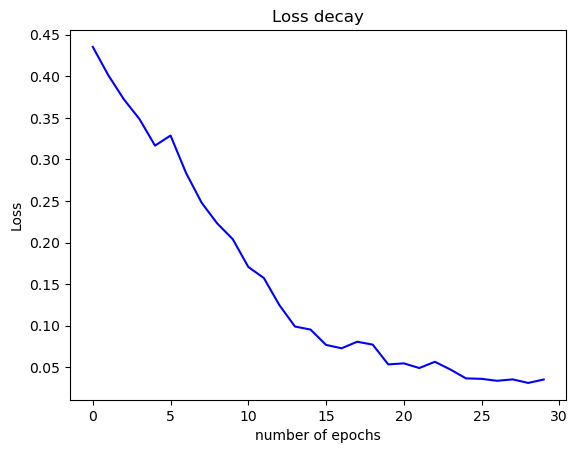

In [41]:
trainer._train_epoch()

In [42]:
# import itertools

# # Define the hyperparameter grid
# hyperparameter_grid = {
#     'model': [Model_v2], # adding more layers # adding more maxpool and make 
#     'lr': [0.001], # imp
#     'weight_decay': [1e-7],
#     'dropout': [0.2], #imp
#     'loss_weight': [0.3,0.5,1.0,1.5,2.0,5.0],
#     'batch_size': [16] # most imp
# }

# # Create a list of all possible combinations of hyperparameters
# hyperparameter_combinations = list(itertools.product(*hyperparameter_grid.values()))

# # Define a function for training and evaluating the model with a given set of hyperparameters
# def train_and_evaluate_model(model_class, lr, weight_decay, dropout, loss_weight, batch_size):
#     # Create the model
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model = model_class(dropout)
#     model.to(device)
#     parameters = filter(lambda p: p.requires_grad, model.parameters())
    
#     # Create the optimizer
#     optimizer = optim.Adam(
#         params=parameters,
#         lr=lr,
#         betas=(0.8, 0.999),
#         eps=1e-8,
#         weight_decay=weight_decay)
#     tensorboard_dir = '/home/ec2-user/SageMaker/runs/'
#     # Create the scheduler
#     lr_warm_up_num = 100
#     cr = 1.0 / math.log(lr_warm_up_num)
#     scheduler = optim.lr_scheduler.LambdaLR(
#         optimizer,
#         lr_lambda=lambda ee: cr * math.log(ee + 1)
#         if ee < lr_warm_up_num else 1)
    
#     # Create the loss criterion
#     data = pd.read_csv('dataset/uncropped/annotations.csv')
#     label_counts = data.iloc[:, 1].value_counts()
#     loss_ratio = label_counts[0] / label_counts[1]
#     weight = torch.Tensor([1,loss_ratio*loss_weight]).to(device)
#     loss_criterion = torch.nn.CrossEntropyLoss(weight=weight)
    
#     # Load the data with the specified batch size
#     dataset_length = len(dataset)
#     train_size = int(0.7 * dataset_length)
#     test_size = dataset_length - train_size
#     train_set, test_set = torch.utils.data.random_split(dataset, [train_size,test_size])

#     train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)
    
#     # Create the Trainer object
#     trainer = Trainer(
#         model, loss_criterion,
#         train_data_loader=train_loader,
#         test_data_loader=test_loader,
#         optimizer=optimizer,
#         epochs=30,
#         with_cuda=True,
#         use_scheduler=True,
#         scheduler=scheduler,
#         save_dir='/home/ec2-user/SageMaker/checkpoints/uncropped/',
#         tensorboard_dir=tensorboard_dir,
#         lr=lr)
    
#     # Train the model
#     trainer._train_epoch()
    
#     # Evaluate the model
#     accuracy = trainer._valid_epoch(model, 0, test_loader)
    
#     return accuracy

# # Perform grid search
# best_accuracy = 0.0
# best_hyperparameters = None

# for hyperparameters in hyperparameter_combinations:
#     model_class, lr, weight_decay, dropout, loss_weight, batch_size = hyperparameters
#     print(f"Training model {model_class.__name__} with lr={lr}, weight_decay={weight_decay}, dropout={dropout}, loss_weight={loss_weight}, batch_size={batch_size}...")
#     accuracy = train_and_evaluate_model(model_class, lr, weight_decay, dropout, loss_weight, batch_size)
#     print(f"Accuracy: {accuracy}%")
    
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_hyperparameters = hyperparameters
        
# print(best_accuracy)
# print(best_hyperparameters)
